# Introduction

#### Project Overview

This project analyzes a student habits/performance dataset containing various features about students and their final exam scores.  
The dataset originally consists of **16 columns** and **1000 rows**.

---

## Project Goals

- Conduct exploratory data analysis to understand the data structure, feature distributions, and potential data quality issues.  
- Preprocess the data, including handling missing values and applying necessary transformations.  
- Engineer meaningful features to enhance model performance.  
- Build and evaluate predictive models to accurately forecast students' final exam scores.  
- Interpret the results to identify key factors affecting exam performance.

---

## Dataset Description

- **Samples:** 1000 students  
- **Features:** 15 columns, including numerical and categorical data  
- **Target variable:** `exam_score` (final result)  
- **Data Source:** the dataset used in this project is available on Kaggle:  
[Student Habits vs Academic Performance](https://www.kaggle.com/datasets/jayaantanaath/student-habits-vs-academic-performance)  
It is distributed under the Apache License 2.0.

Please refer to the Kaggle page and the license for details regarding usage and redistribution.

---

# Preparation

## Step Overview: Preparation

In this step, we prepare everything necessary for our work, including:

- Importing all required libraries (e.g., pandas, numpy, matplotlib, seaborn, various sklearn modules)
- Setting pandas options for better data handling and display
- Defining custom functions to simplify repetitive processes
- Loading the dataset

## 1. Imports

In [72]:
# Basic
import numpy as np
import pandas as pd

# Data Preparation
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from scipy.stats import zscore, boxcox
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Modeling
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import (
    LinearRegression, Lasso, Ridge, 
    ElasticNet, LogisticRegression
)
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# Evaluation Metrics
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, 
    explained_variance_score, 
    median_absolute_error, 
    max_error
)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Settings

In [2]:
pd.set_option('display.max_columns', None)

## 3. Functions Defintion

In [3]:
# ================================================================
# DETECT MISSING VALUES — detects and return missing values in the dataset
# ================================================================

def detect_missing_values(data):
    """
    Detect missing values in a DataFrame and return a report.

    Parameters
    ----------
    data : pandas.DataFrame
        The dataset to check for missing values.

    Returns
    -------
    pandas.DataFrame or None
        A DataFrame containing the count and percentage of missing values for each column 
        that has at least one missing entry. Returns None if no missing values are found.

    Notes
    -----
    - Prints a message indicating whether missing values were found.
    - If not empty, the output DataFrame has two columns:
        - 'missing_count': total number of missing values per column
        - 'missing_%': percentage of missing values per column
    """
    miss_rep = pd.concat([data.isnull().sum(), data.isnull().mean()*100], axis=1)
    miss_rep.columns = ['missing_count', 'missing_%']
    miss_rep = miss_rep[miss_rep['missing_count'] > 0]
    if not miss_rep.empty:
        print('Some missing values were detected!')
        return miss_rep
    else: 
        print('No missing values detected!')

# ================================================================
# COUNT PLOTS — visualization of categorical features
# ================================================================

def create_countplots(data, features, ax_cols=2):
    """
    Create countplots for a list of categorical features from a DataFrame.

    Parameters
    ----------
    data : pandas.DataFrame
        The dataset containing the categorical columns to be visualized.

    features : list of str
        List of categorical column names from the DataFrame to plot.

    ax_cols : int, optional (default=2)
        Number of subplot columns (i.e., how many plots per row).

    Returns
    -------
    None
        The function displays the plots using matplotlib and does not return anything.

    Notes
    -----
    - Each feature is plotted using seaborn's countplot.
    - Axes layout is dynamically calculated based on the number of features and `ax_cols`.
    - Unused subplots (if any) are automatically removed from the final figure.
    - Feature names are prettified (underscores removed, title case applied) for better readability.
    """
    # defines axes and create figure
    ax_rows = (len(features) + ax_cols - 1) // ax_cols
    fig, axes = plt.subplots(ax_rows, ax_cols, figsize=(10,4*ax_rows))

    # assures axes is 2D-array
    if ax_rows == 1 and ax_cols == 1:
        axes = np.array([[axes]])
    elif ax_rows == 1:
        axes = np.array([axes])
    elif ax_cols == 1:
        axes = np.array([axes]).T

    # creates countplots
    for i, col in enumerate(features):
        r, c = i // ax_cols, i % ax_cols   # calculation of coordinates

        # transforms names of columns to look prettier on plots
        pretty_column_title = col.replace('_',' ').title()

        # basic plotting part
        sns.countplot(data=data, x=col, order=data[col].value_counts().index, ax=axes[r,c])
        axes[r,c].set_xlabel(pretty_column_title, fontsize=8, fontweight='bold')
        axes[r,c].set_ylabel('Qty', fontsize=8, fontweight='bold')
        axes[r,c].set_title(pretty_column_title, fontsize=12, fontweight='bold')
        axes[r,c].grid(axis='y', linestyle='--',alpha=0.7)

    # deletes non-used axes
    for j in range(len(features), ax_rows*ax_cols):
        r, c = j // ax_cols, j % ax_cols
        fig.delaxes(axes[r,c])

    # plot display
    plt.tight_layout()
    plt.show()


# ================================================================
# HIST PLOTS — visualization of numerical features
# ================================================================
def create_histplots(data, features, ax_cols=2, bins=10):
    """
    Create histplots for a list of numerical features from a DataFrame.

    Parameters
    ----------
    data : pandas.DataFrame
        The dataset containing the categorical columns to be visualized.

    features : list of str
        List of numerical column names from the DataFrame to plot.

    ax_cols : int, optional (default=2)
        Number of subplot columns (i.e., how many plots per row).

    Returns
    -------
    None
        The function displays the plots using matplotlib and does not return anything.

    Notes
    -----
    - Each feature is plotted using seaborn's histplot.
    - Axes layout is dynamically calculated based on the number of features and `ax_cols`.
    - Unused subplots (if any) are automatically removed from the final figure.
    - Feature names are prettified (underscores removed, title case applied) for better readability.
    """
    
    # defines axes and create figure
    ax_rows = (len(features) + ax_cols - 1) // ax_cols
    fig, axes = plt.subplots(ax_rows, ax_cols, figsize=(10,4*ax_rows))

    # assures axes is 2D-array
    if ax_rows == 1 and ax_cols == 1:
        axes = np.array([[axes]])
    elif ax_rows == 1:
        axes = np.array([axes])
    elif ax_cols == 1:
        axes = np.array([axes]).T

    # creates histplots
    for i, col in enumerate(features):
        r, c = i // ax_cols, i % ax_cols   # calculation of coordinates

        # transforms names of columns to look prettier on plots
        pretty_column_title = col.replace('_',' ').title()

        # create custom bins for histogram using 'bins' parameter
        bin_edges = np.linspace(data[col].min(), data[col].max(), bins+1)
        
        # basic plotting part
        sns.histplot(data=data, x=col, bins=bin_edges, ax=axes[r,c])
        axes[r,c].set_xlabel(pretty_column_title, fontsize=8, fontweight='bold')
        axes[r,c].set_ylabel('Qty', fontsize=8, fontweight='bold')
        axes[r,c].set_title(pretty_column_title, fontsize=12, fontweight='bold')
        axes[r,c].grid(axis='y', linestyle='--',alpha=0.7)
        axes[r,c].set_xticks(bin_edges)
        axes[r,c].set_xticklabels(np.round(bin_edges,2), rotation=45)

    # deletes non-used axes
    for j in range(len(features), ax_rows*ax_cols):
        r, c = j // ax_cols, j % ax_cols
        fig.delaxes(axes[r,c])

    # plot display
    plt.tight_layout()
    plt.show()


# ================================================================
# BOX PLOTS — visualization of categorical features distribution among target value
# ================================================================

def create_boxplots(data, features, target, ax_cols=2, grid_step=5):
    """
    Create boxplots to visualize the distribution of a numerical target variable 
    across different categorical features.

    Parameters
    ----------
    data : pandas.DataFrame
        The dataset containing the target and categorical features.

    features : list of str
        List of categorical column names used as X-axis variables in each boxplot.

    target : str
        Name of the numeric target column to be used on the Y-axis.

    ax_cols : int, optional (default=2)
        Number of subplot columns (plots per row).

    grid_step : int or float, optional (default=5)
        Step size for Y-axis grid and tick marks, to improve interpretability.

    Returns
    -------
    None
        The function displays a grid of boxplots using matplotlib and seaborn. It does not return any object.

    Notes
    -----
    - Titles and labels are automatically prettified for display (underscores removed, title-cased).
    - If the total number of subplots exceeds the number of features, unused axes are removed.
    - The Y-axis ticks are customized using `grid_step`, and horizontal grid lines are shown for better value estimation.
    """
    # defines axes and create figure
    
    ax_rows = (len(features) + ax_cols - 1) // ax_cols
    fig, axes = plt.subplots(ax_rows, ax_cols, figsize=(10,6*ax_rows))

    # assures axes is 2D-array
    if ax_rows == 1 and ax_cols == 1:
        axes = np.array([[axes]])
    elif ax_rows == 1:
        axes = np.array([axes])
    elif ax_cols == 1:
        axes = np.array([axes]).T

    # creates boxplots
    for i, col in enumerate(features):
        r, c = i // ax_cols, i % ax_cols   # calculation of coordinates

        # transforms names of columns to look prettier on plots
        pretty_x_title = col.replace('_',' ').title()
        pretty_y_title = target.replace('_',' ').title()

        # basic plotting part
        sns.boxplot(data=data, x=col, y=target, ax=axes[r,c])
        axes[r,c].set_xlabel( pretty_x_title, fontsize=8, fontweight='bold')
        axes[r,c].set_ylabel(pretty_y_title, fontsize=8, fontweight='bold')
        axes[r,c].set_title(f"""{pretty_x_title}\ncorrelation with\n{pretty_y_title}""", 
                            fontsize=12, 
                            fontweight='bold')
        axes[r,c].grid(axis='y', linestyle='--',alpha=0.7)

        # create custom grid with use of 'grid_step' parameter
        start = np.floor(data[target].min() / 10) * 10
        end = np.ceil(data[target].max() / 10) * 10 + 5
        axes[r,c].set_yticks(np.arange(start,end,grid_step))
            
    # deletes non-used axes
    for j in range(len(features), ax_rows*ax_cols):
        r, c = j // ax_cols, j % ax_cols
        fig.delaxes(axes[r,c])

    # plot display
    plt.tight_layout()
    plt.show()


# ================================================================
# IDENTIFY OUTLIER — identifies outliers using IQR and ZScore
# ================================================================

def identify_outliers(data, features):
    """
    Identify outliers in specified numeric features using the IQR method.

    Parameters
    ----------
    data : pandas.DataFrame
        The dataset containing the features to analyze.

    features : list of str
        List of numerical column names to check for outliers.

    Returns
    -------
    outliers_set : set
        A set containing numerical columns names where at least one outlier is detected.

    Side Effects
    ------------
    - Prints detailed information for each column where outliers are detected:
        - Name of the feature (in uppercase)
        - Indexes of the outlier rows
        - Corresponding outlier values
        - Median value of the feature for reference

    Notes
    -----
    - Outliers are detected using the standard IQR rule:
        - Lower Bound = Q1 - 1.5 * IQR
        - Upper Bound = Q3 + 1.5 * IQR
    - This function is primarily for **exploratory analysis** and **debugging**. 
    - It assumes that all specified features are numeric and do not contain NaNs.
    """
    
    outliers_set = set()
    for col in features:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + 1.5*IQR
        lower_bound = Q1 - 1.5*IQR
        outliers = data[(data[col]>upper_bound)|(data[col]<lower_bound)]
        outliers_set.update(i for i in outliers.index)
        if not outliers.empty:
            print(f"[IQR] {col.upper()} \ncontains outlier(s) with index(es):\n{outliers.index.values} with values of \n{outliers[col].values} \nand median value of {data[col].median()}\n" )

# ================================================================
# EVALUATE KURTOSIS — evaluates kurtosis of numerical features
# ================================================================
def evaluate_kurtosis(data, features , detailed=False):
    """
    Evaluate the kurtosis of specified numerical features in the dataset.

    Parameters
    ----------
    data : pandas.DataFrame
        The dataset containing the features to evaluate.

    features : list of str
        List of numerical column names whose kurtosis will be checked.

    detailed : bool, optional (default=False)
        If True, prints the kurtosis value for all features, even if within normal range.
        If False, prints only warnings for features with high kurtosis (> 3).

    Returns
    -------
    high_kurtosis_cols : list of str
        List of column names where kurtosis exceeds 3, indicating heavy tails.
    """
    
    high_kurtosis_cols = []
    message=True
    
    for col in features:
        col_kurt = data[col].kurt()
        if (col_kurt > 3):
            print(f"!HIGH! kurtosis found on column {col.capitalize()} with value of {col_kurt:.2f}\n")
            message=False
            high_kurtosis_cols.append(col)
        elif detailed:
            print(f"NORMAL Kurtosis on column {col.capitalize()} with value of {col_kurt:.2f}\n")
            
    if message:
        print("Kurtosis of dataset is ok!")
        
    return high_kurtosis_cols


# ================================================================
# GENERATES SKEW INSTRUCTION — evaluates skewness of numerical features
# ================================================================
def generate_skew_instructions(data, features , detailed=False, high_skew_transformer='log', extra_high_skew_transformer='yeo-johnson'):    
    """
    Analyze skewness of numerical features and generate transformation instructions.

    This function scans the specified features in the dataset, evaluates their skewness,
    and, if skewness if high, returns a dictionary with appropriate transformation methods to reduce skewness 
    for highly skewed features.

    Parameters
    ----------
    data : pandas.DataFrame
        The dataset containing the numerical features to be evaluated.

    features : list of str
        List of numerical column names to evaluate for skewness.

    detailed : bool, optional (default=False)
        If True, prints skewness values for all features, including those with normal skew.

    high_skew_transformer : str, optional (default='log')
        Transformation method to suggest for moderately skewed features (|skew| > 0.5 and ≤ 1).
        Common values: 'log', 'sqrt', etc.

    extra_high_skew_transformer : str, optional (default='yeo-johnson')
        Transformation method to suggest for highly skewed features (|skew| > 1).
        Common values: 'yeo-johnson', 'box-cox', etc.

    Returns
    -------
    transform_instructions : dict
        A dictionary mapping column names to the suggested transformation method.

        Example:
        {
            'feature_1': 'log',
            'feature_2': 'yeo-johnson'
        }

    Notes
    -----
    - Skewness thresholds:
        |skew| > 1       : extra high skewness
        0.5 < |skew| ≤ 1 : high skewness
        |skew| ≤ 0.5     : acceptable (no action recommended)
    """
    
    transform_instructions = {}

    for col in features:
        col_skew = data[col].skew()
        
        if abs(col_skew) > 1:
            print(f"!EXTRA HIGH! Skewness found on column \"{col.capitalize()}\" with value of {col_skew:.2f}\n")
            transform_instructions[col] = extra_high_skew_transformer
        elif abs(col_skew) > 0.5:
            print(f"!HIGH! Skewness found on column \"{col.capitalize()}\" with value of {col_skew:.2f}\n")
            transform_instructions[col] = high_skew_transformer
        elif detailed:
            print(f"NORMAL Skewness on column \"{col.capitalize()}\" with value of {col_skew:.2f}\n")

    if not transform_instructions:
        print("Skewness of dataset is ok!")
    
    return transform_instructions


# ================================================================
# CREATE REGRESSION MODELS — create regression models dict
# ================================================================
def create_regression_models(random_state=56):
    """
    Create a dictionary of commonly used regression models for benchmarking.

    This function initializes and returns a dictionary of several regression models. 
    These models can be used to compare performance
    during the model selection phase of a machine learning pipeline.

    Parameters
    ----------
    random_state : int, optional (default=56)
        The seed for models that support random number generation.
        Ensures reproducibility of results.

    Returns
    -------
    models : dict
        A dictionary where keys are string names of regression models and values are
        the corresponding initialized model objects.

    Notes
    -----
    The models included:
    - LinearRegression
    - Lasso (L1 regularization)
    - Ridge (L2 regularization)
    - ElasticNet (combined L1 and L2)
    - SVR (Support Vector Regression with RBF kernel)
    - DecisionTreeRegressor
    - RandomForestRegressor
    - GradientBoostingRegressor
    - XGBRegressor (requires `xgboost` library)

    All models are returned with default hyperparameters, unless specified otherwise.
    """
    return {'Linear_Regression':LinearRegression(),
              'Lasso_Regression':Lasso(),
              'Ridge Regression':Ridge(),
              'ElasticNet_Regression':ElasticNet(),
              'SVR':SVR(kernel='rbf', C=1.0, epsilon=0.),
              'Decision_Tree_Regressor':DecisionTreeRegressor(random_state=random_state),
              'Random_Forest_Regressor':RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=random_state),
              'Gradient_Boosting_Regressor':GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=random_state, max_depth=3),
              'XGB_Regressor':XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=random_state, max_depth=3)
            }
# ================================================================
# EVALUATE REGRESSION MODELS — evaluates regression models based on r2, mse, mae, rmse
# ================================================================
def evaluate_regression_models(X, y, preproc_pipe_steps, models, test_size=0.25, random_state=56):
    """
    Evaluate multiple regression models using a common preprocessing pipeline.

    This function performs train/test splitting, applies a predefined set of
    preprocessing steps (via sklearn Pipeline), trains each model, and evaluates
    them using standard regression metrics.

    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix containing predictors.
    
    y : pd.Series or np.ndarray
        Target vector (regression target values).
    
    preproc_pipe_steps : list of tuples
        List of preprocessing steps to be used in the sklearn Pipeline.
        Each step is a tuple in the form: ('name', transformer).
        Example: [('preprocessor', column_transformer)]

    models : dict
        Dictionary of regression models to evaluate.
        Format: {'ModelName': model_object, ...}

    test_size : float, optional (default=0.25)
        Proportion of the dataset to include in the test split.

    random_state : int, optional (default=56)
        Seed used by the random number generator for reproducibility.

    Returns
    -------
    result_df : pd.DataFrame
        DataFrame sorted by descending R² score.
        Contains the following evaluation metrics for each model:
        - 'Model' : str
        - 'R2_Score' : float
        - 'Explained_Variance' : float
        - 'MSE' : float
        - 'Median_AE' : float
        - 'MAE' : float
        - 'RMSE' : float
        - 'Max_Error' : float
    """
    results = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state) 
    for mod_name, model in models.items():
        steps = preproc_pipe_steps + [('estimator', model)]
        pipe = Pipeline(steps=steps)
        pipe.fit(X_train, y_train)
        
        yhat = pipe.predict(X_test)
        mse = np.round(mean_squared_error(y_test, yhat), 2)
        r2 = np.round(r2_score(y_test, yhat), 2)
        mae = np.round(mean_absolute_error(y_test, yhat), 2)
        rmse = np.round(np.sqrt(mse), 2)
        med_ae = np.round(median_absolute_error(y_test, yhat), 2)
        ex_var = np.round(explained_variance_score(y_test, yhat), 2)
        max_err = np.round(max_error(y_test, yhat), 2)
        results.append(
            {
                'Model':mod_name,
                'R2_Score':r2,
                'Explained_Variance':ex_var,
                'MSE':mse,
                'Median_AE':med_ae,
                'MAE':mae,
                'RMSE':rmse,
                'Max_Error':max_err,
            }
        )
    result_df = pd.DataFrame(results).sort_values('R2_Score', ascending=False).reset_index(drop=True)
    return result_df


# ================================================================
# FINAL REGRESSION MODELS EVALUATION — evaluates refined regression model
# ================================================================
def final_reg_models_evaluation(X_train_val, X_final_test, y_train_val, y_final_test, preproc_pipe_steps, models):
    """
    Evaluates final regression models on hold-out test data after training on the full training/validation set.

    This function trains each specified regression model on the full training+validation data 
    and evaluates their generalization performance on a final, untouched test set. It wraps 
    preprocessing steps and models into sklearn Pipelines and computes standard regression metrics.

    Parameters
    ----------
    X_train_val : pd.DataFrame
        Feature matrix used for training (combined training and validation set).

    X_final_test : pd.DataFrame
        Feature matrix for the final evaluation (unseen test set).

    y_train_val : pd.Series or np.ndarray
        Target values for training data.

    y_final_test : pd.Series or np.ndarray
        True target values for final test data.

    preproc_pipe_steps : list of tuples
        Preprocessing steps to apply inside the pipeline before model training.
        Format: [('step_name', transformer), ...]

    models : dict
        Dictionary with model names as keys and sklearn-compatible 
        regression estimators with chosen hyperparameters as values.
        

    Returns
    -------
    result_df : pd.DataFrame
        DataFrame sorted by descending R² score.
        Includes the following evaluation metrics for each model:
            - 'Model'
            - 'R2_Score'
            - 'Explained_Variance'
            - 'MSE' (Mean Squared Error)
            - 'Median_AE' (Median Absolute Error)
            - 'MAE' (Mean Absolute Error)
            - 'RMSE' (Root Mean Squared Error)
            - 'Max_Error'
    """
    results = [] 
    for mod_name, model in models.items():
        steps = preproc_pipe_steps + [('estimator', model)]
        pipe = Pipeline(steps=steps)
        pipe.fit(X_train_val, y_train_val)
        
        yhat = pipe.predict(X_final_test)
        mse = np.round(mean_squared_error(y_final_test, yhat), 4)
        r2 = np.round(r2_score(y_final_test, yhat), 4)
        mae = np.round(mean_absolute_error(y_final_test, yhat), 4)
        rmse = np.round(np.sqrt(mse), 4)
        med_ae = np.round(median_absolute_error(y_final_test, yhat), 4)
        ex_var = np.round(explained_variance_score(y_final_test, yhat), 4)
        max_err = np.round(max_error(y_final_test, yhat), 4)
        results.append(
            {
                'Model':mod_name,
                'R2_Score':r2,
                'Explained_Variance':ex_var,
                'MSE':mse,
                'Median_AE':med_ae,
                'MAE':mae,
                'RMSE':rmse,
                'Max_Error':max_err,
            }
        )
    result_df = pd.DataFrame(results).sort_values('R2_Score', ascending=False).reset_index(drop=True)
    return result_df

## 4. Load Data

In [4]:
df = pd.read_csv('student_habits_performance.csv')

# Data Overview

## Step Overview: Data Overview

In this step, we'll take an initial look at our dataset. This includes:  
- Examining data samples with `.head()`, `.tail()`, and `.sample()`  
- Checking data structure and summary statistics using `.info()` and `.describe()`  
- Reviewing metadata such as dataset shape, column names, and data types  
- Analyzing the distribution of the target variable

## 5. EDA. Basic Data Audit

### 5.1 Samples

In [5]:
df.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [6]:
df.tail()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
995,S1995,21,Female,2.6,0.5,1.6,No,77.0,7.5,Fair,2,High School,Good,6,Yes,76.1
996,S1996,17,Female,2.9,1.0,2.4,Yes,86.0,6.8,Poor,1,High School,Average,6,Yes,65.9
997,S1997,20,Male,3.0,2.6,1.3,No,61.9,6.5,Good,5,Bachelor,Good,9,Yes,64.4
998,S1998,24,Male,5.4,4.1,1.1,Yes,100.0,7.6,Fair,0,Bachelor,Average,1,No,69.7
999,S1999,19,Female,4.3,2.9,1.9,No,89.4,7.1,Good,2,Bachelor,Average,8,No,74.9


In [7]:
df.sample(5)

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
577,S1577,22,Female,1.9,2.9,1.6,Yes,87.6,6.1,Fair,4,Bachelor,Good,1,Yes,44.4
35,S1035,21,Female,4.2,1.7,0.0,Yes,84.2,6.5,Good,1,Bachelor,Average,3,No,72.6
56,S1056,24,Male,2.5,2.0,0.0,No,83.9,5.3,Good,6,Bachelor,Average,8,No,66.7
753,S1753,18,Male,4.3,3.4,0.9,No,83.3,5.7,Fair,1,Master,Good,2,No,59.2
654,S1654,22,Female,3.1,4.7,0.4,No,79.5,6.2,Good,4,Master,Good,9,No,71.5


### 5.2 Dataset Statistics

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   student_id                     1000 non-null   object 
 1   age                            1000 non-null   int64  
 2   gender                         1000 non-null   object 
 3   study_hours_per_day            1000 non-null   float64
 4   social_media_hours             1000 non-null   float64
 5   netflix_hours                  1000 non-null   float64
 6   part_time_job                  1000 non-null   object 
 7   attendance_percentage          1000 non-null   float64
 8   sleep_hours                    1000 non-null   float64
 9   diet_quality                   1000 non-null   object 
 10  exercise_frequency             1000 non-null   int64  
 11  parental_education_level       909 non-null    object 
 12  internet_quality               1000 non-null   ob

In [9]:
df.describe(include=['float64','int64'])

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score
count,1000.0000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.4980,3.55010,2.505500,1.819700,84.131700,6.470100,3.042000,5.438000,69.601500
std,2.3081,1.46889,1.172422,1.075118,9.399246,1.226377,2.025423,2.847501,16.888564
min,17.0000,0.00000,0.000000,0.000000,56.000000,3.200000,0.000000,1.000000,18.400000
25%,18.7500,2.60000,1.700000,1.000000,78.000000,5.600000,1.000000,3.000000,58.475000
50%,20.0000,3.50000,2.500000,1.800000,84.400000,6.500000,3.000000,5.000000,70.500000
75%,23.0000,4.50000,3.300000,2.525000,91.025000,7.300000,5.000000,8.000000,81.325000
max,24.0000,8.30000,7.200000,5.400000,100.000000,10.000000,6.000000,10.000000,100.000000


In [10]:
df.describe(include='object')

,student_id,gender,part_time_job,diet_quality,parental_education_level,internet_quality,extracurricular_participation
count,1000,1000,1000,1000,909,1000,1000
unique,1000,3,2,3,3,3,2
top,S1999,Female,No,Fair,High School,Good,No
freq,1,481,785,437,392,447,682


In [11]:
print(df.columns)
print()
print(df.dtypes)
print()
print(df.shape)

Index(['student_id', 'age', 'gender', 'study_hours_per_day',
       'social_media_hours', 'netflix_hours', 'part_time_job',
       'attendance_percentage', 'sleep_hours', 'diet_quality',
       'exercise_frequency', 'parental_education_level', 'internet_quality',
       'mental_health_rating', 'extracurricular_participation', 'exam_score'],
      dtype='object')

student_id                        object
age                                int64
gender                            object
study_hours_per_day              float64
social_media_hours               float64
netflix_hours                    float64
part_time_job                     object
attendance_percentage            float64
sleep_hours                      float64
diet_quality                      object
exercise_frequency                 int64
parental_education_level          object
internet_quality                  object
mental_health_rating               int64
extracurricular_participation     object
exam_score         

In [12]:
print(df['student_id'].nunique())
print(df.shape[0])

1000
1000


### 5.3 Target Values Analysis

In [13]:
df['exam_score'].describe()

count    1000.000000
mean       69.601500
std        16.888564
min        18.400000
25%        58.475000
50%        70.500000
75%        81.325000
max       100.000000
Name: exam_score, dtype: float64

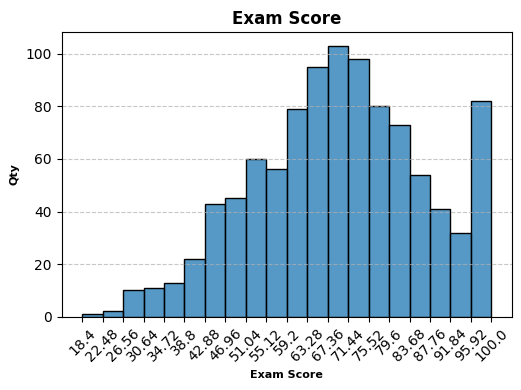

In [14]:
create_histplots(data=df, features=['exam_score'], bins=20)

## Step Conclusion: Data Overview
- The target variable, representing students' exam scores, ranges from **18.4** to **100**, with an average of **69.6** and a standard deviation of **16.9**.  
- Its distribution is approximately normal but shows a **slight skew towards higher scores**, which is expected given the nature of exam results.  
This minor imbalance is unlikely to adversely affect modeling.  

- We verified that the `student_id` column contains only unique values, making it suitable as a unique identifier if needed.  

- Overall, the dataset has 16 columns and 1000 rows, matching our expectations and confirming the data was loaded correctly.  
- Numerical features are properly typed as `integer` or `floats`, and categorical features are stored as `objects`.  
- However, there are some missing values that will need to be addressed in later preprocessing steps.

# Data Cleaning and Preparation

## Step Overview: Data Cleaning and Preparation

In this step, we will:

- Handle **missing values** and **duplicates** to ensure data quality.  
- Analyze distributions of **categorical** and **numerical features** to detect potential issues like outliers, imbalances, or invalid values.  
- Split the dataset into features (X) and target (y) for modeling.  
- Perform **outlier analysis** and assess **kurtosis** to identify extreme values.  
- Evaluate **skewness** to determine if any transformations are needed for better data symmetry.  
- Build a **baseline model** to establish a reference for further improvements.  
- Develop a **transformer pipeline** with **feature engineering** to automate preprocessing steps while avoiding data leakage.  
- Analyze **multicollinearity** and create a transformer to **drop highly correlated features** to improve model stability.


## 6. Handling Missing Values

In [15]:
detect_missing_values(data=df)

Some missing values were detected!


,missing_count,missing_%
parental_education_level,91,9.1


---
#### Missing values account for approximately **9.1%** of our dataset.  
We can address this by replacing parental education level missing entries with the category `'unknown'`  
and then mapping it as the lowest value in the ordinal encoder.  

This approach preserves the information about missingness while integrating it properly into the model.

---

In [16]:
df['parental_education_level'] = df['parental_education_level'].replace(np.nan, 'unknown')

In [17]:
detect_missing_values(data=df)

No missing values detected!


## 7. Handling Duplicates

In [18]:
print(df.duplicated().sum())
print(df.duplicated(subset='student_id').sum())

0
0


## 8. Data Values Distribution Analysis

### 8.1 Categorical Features Analysis 

#### Analyzing the cardinality (number of unique categories) of categorical variables in the data.

In [19]:
cat_cols = df.drop(columns='student_id').select_dtypes('object').columns.tolist()

In [20]:
for col in cat_cols:
    print(f"Column \"{col}\" : {df[col].nunique()} unique values\n")

Column "gender" : 3 unique values

Column "part_time_job" : 2 unique values

Column "diet_quality" : 3 unique values

Column "parental_education_level" : 4 unique values

Column "internet_quality" : 3 unique values

Column "extracurricular_participation" : 2 unique values



In [21]:
for col in cat_cols:
    df[col] = df[col].str.lower().str.strip()
    print(df[col].value_counts(dropna=False), "\n")

gender
female    481
male      477
other      42
Name: count, dtype: int64 

part_time_job
no     785
yes    215
Name: count, dtype: int64 

diet_quality
fair    437
good    378
poor    185
Name: count, dtype: int64 

parental_education_level
high school    392
bachelor       350
master         167
unknown         91
Name: count, dtype: int64 

internet_quality
good       447
average    391
poor       162
Name: count, dtype: int64 

extracurricular_participation
no     682
yes    318
Name: count, dtype: int64 



#### Generating countplots for categorical features
These plots provide a clear visualization of the value distribution within each categorical variable.

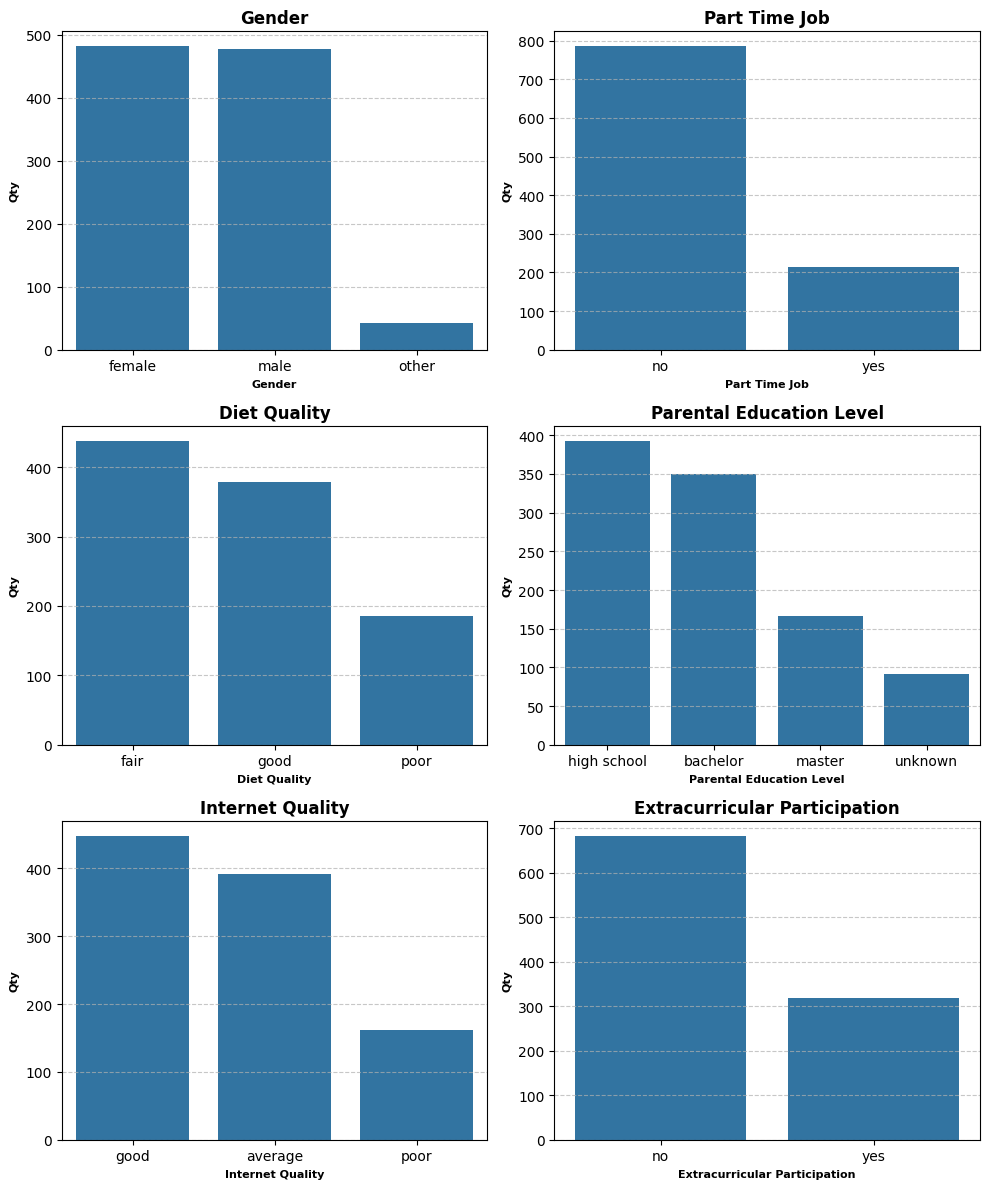

In [22]:
create_countplots(data=df, features=cat_cols)

### 8.2 Numerical Features Analysis

#### Generating histplots for numerical features
These plots provide a clear visualization of the value distribution within each numerical variable.

In [23]:
num_cols = df.drop(columns='exam_score').select_dtypes(['int64','float64']).columns.tolist()

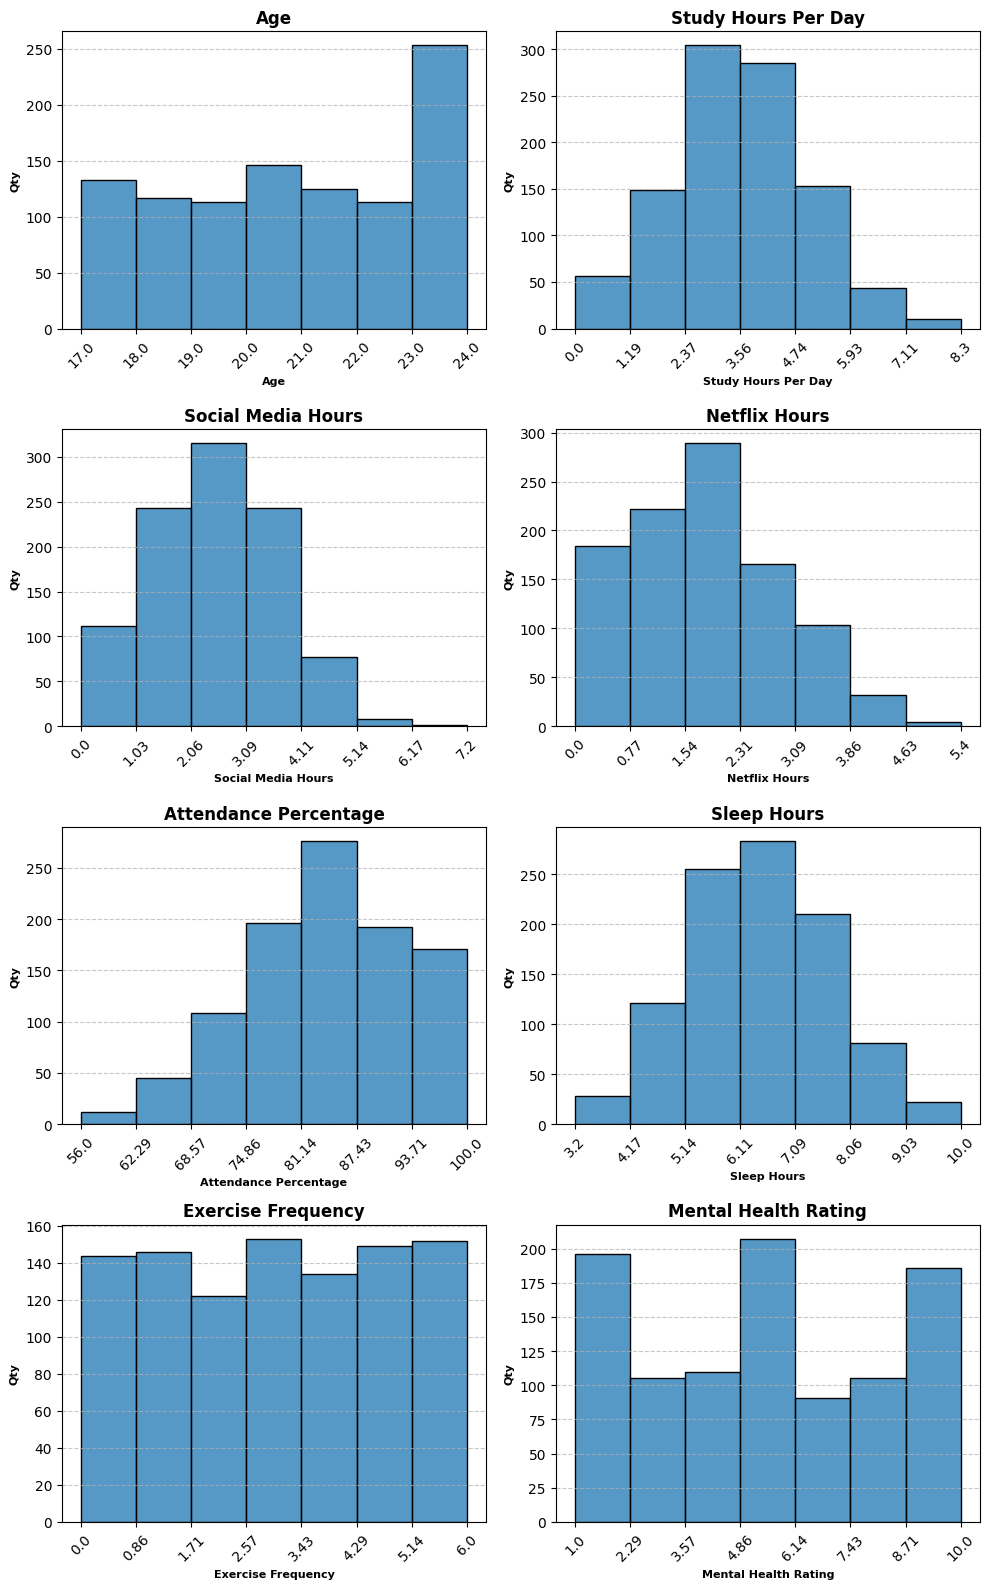

In [24]:
create_histplots(data=df, features=num_cols, bins=7)

## 9. Feature / Target Split

In [25]:
y = df['exam_score']
X = df.drop(columns='exam_score').copy()

In [26]:
X.shape[0] == y.shape[0]

True

## 10. Handling Outliers + Kurtosis Analysis

### 10.1 Kurtosis Analysis

In [27]:
if not evaluate_kurtosis(data=X, features=num_cols, detailed=False):
    print('Kutosis of training set is ok!')
else:
    print('Some transformation required to reduced kurtosis')

Kurtosis of dataset is ok!
Kutosis of training set is ok!


### 10.2 IQR / Z-Score Analysis

In [28]:
identify_outliers(data=df, features=num_cols)

[IQR] STUDY_HOURS_PER_DAY 
contains outlier(s) with index(es):
[ 73 293 455 489 774 797 875] with values of 
[7.4 7.4 8.3 7.4 7.5 8.2 7.6] 
and median value of 3.5

[IQR] SOCIAL_MEDIA_HOURS 
contains outlier(s) with index(es):
[145 346 361 641 735] with values of 
[6.2 6.  6.1 5.7 7.2] 
and median value of 2.5

[IQR] NETFLIX_HOURS 
contains outlier(s) with index(es):
[ 81 556 822 887] with values of 
[5.  5.4 5.3 4.9] 
and median value of 1.8

[IQR] ATTENDANCE_PERCENTAGE 
contains outlier(s) with index(es):
[651 706 971] with values of 
[57.6 56.7 56. ] 
and median value of 84.4

[IQR] SLEEP_HOURS 
contains outlier(s) with index(es):
[802 955] with values of 
[10. 10.] 
and median value of 6.5



In [29]:
class OutlierFeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self, some_param=1):
        self.some_param = some_param
    def fit(self, X, y=None):
        X = X.copy()
        self.num_cols = X.select_dtypes(include='number').columns.tolist()
        self.outliers_set = set()
        
        for col in self.num_cols:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            upper_bound = Q3 + 1.5*IQR
            lower_bound = Q1 - 1.5*IQR
            outliers = X[(X[col]>upper_bound)|(X[col]<lower_bound)]
            self.outliers_set.update(i for i in outliers.index)
    
        self.is_fitted_ = True
        return self
    def transform(self, X):
        X = X.copy()
        X['iqr_outlier'] = X.index.isin(self.outliers_set)
        X['zscore_outlier'] = (np.abs(X[self.num_cols].apply(zscore)) > 3).any(axis=1)
        X['is_outlier'] = X['iqr_outlier'] & X['zscore_outlier']
        return X

## 11. Skewness Analysis

In [30]:
if not generate_skew_instructions(data=X, features=num_cols, detailed=True):
    print('Skewness of training set is ok!')
else:
    print('Some transformation required to reduced skewness')

NORMAL Skewness on column "Age" with value of 0.01

NORMAL Skewness on column "Study_hours_per_day" with value of 0.05

NORMAL Skewness on column "Social_media_hours" with value of 0.12

NORMAL Skewness on column "Netflix_hours" with value of 0.24

NORMAL Skewness on column "Attendance_percentage" with value of -0.24

NORMAL Skewness on column "Sleep_hours" with value of 0.09

NORMAL Skewness on column "Exercise_frequency" with value of -0.03

NORMAL Skewness on column "Mental_health_rating" with value of 0.04

Skewness of dataset is ok!
Skewness of training set is ok!


In [31]:
X.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation
0,S1000,23,female,0.0,1.2,1.1,no,85.0,8.0,fair,6,master,average,8,yes
1,S1001,20,female,6.9,2.8,2.3,no,97.3,4.6,good,6,high school,average,8,no
2,S1002,21,male,1.4,3.1,1.3,no,94.8,8.0,poor,1,high school,poor,1,no
3,S1003,23,female,1.0,3.9,1.0,no,71.0,9.2,poor,4,master,good,1,yes
4,S1004,19,female,5.0,4.4,0.5,no,90.9,4.9,fair,3,master,good,1,no


## 12. Building a Baseline

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=56)

baseline_pipe = Pipeline(steps=[
    ('outliers_flags_adder', OutlierFeatureAdder()),
    ('estimator',DummyRegressor(strategy='mean'))
])

baseline_pipe.fit(X_train, y_train)
yhat = baseline_pipe.predict(X_test)

baseline_mse = np.round(mean_squared_error(y_test, yhat),2)
baseline_mae = np.round(mean_absolute_error(y_test, yhat),2)
baseline_sqrmse = np.round(np.sqrt(baseline_mse),2)
baseline_scores = {'MSE': baseline_mse, 'MAE':baseline_mae, 'SQRMSE':baseline_sqrmse}

print("Baseline Model Results:")
for name,score in baseline_scores.items():
    print(f"{name:<8}: {score}")

Baseline Model Results:
MSE     : 263.57
MAE     : 12.92
SQRMSE  : 16.23


## 13. Feature Engineering Pipeline

In [33]:
X_train.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation
838,S1838,20,male,3.3,2.9,3.6,no,88.1,5.2,fair,4,bachelor,average,8,yes
482,S1482,21,male,3.4,1.5,0.7,no,79.3,7.1,fair,1,unknown,poor,1,no
983,S1983,21,male,3.9,1.8,2.1,no,74.0,6.5,poor,2,master,average,2,no
978,S1978,24,female,1.6,3.1,2.8,no,82.7,7.8,fair,0,bachelor,good,5,yes
317,S1317,17,male,4.1,4.2,0.0,no,70.2,6.9,good,1,high school,average,8,yes


In [34]:
class DropStudentId(BaseEstimator, TransformerMixin):
    def __init__(self, some_param=1):
        self.some_param = some_param
        
    def fit(self, X, y=None):
        self.is_fitted_ = True
        return self
    def transform(self, X):
        X = X.copy()
        if 'student_id' in X.columns:
            X = X.drop(columns='student_id')
        return X

class NightOwlFeature(BaseEstimator, TransformerMixin):
    def __init__(self, sleep_treshold=6):
        self.sleep_treshold = sleep_treshold
    def fit(self, X, y=None):
        self.is_fitted_ = True
        return self
    def transform(self, X):
        X = X.copy()
        X['is_night_owl'] = (X['sleep_hours']<self.sleep_treshold).astype('int')
        return X


class AgeFlags(BaseEstimator, TransformerMixin):
    def __init__(self, some_param=1):
        self.some_param = some_param
    def fit(self, X, y=None):
        self.is_fitted_ = True
        return self
    def transform(self, X):
        X = X.copy()
        X['atleast_18_y_o'] = (X['age']>=18).astype('int')
        X['atleast_21_y_o'] = (X['age']>=21).astype('int')
        return X


class TotalLeisureHours(BaseEstimator, TransformerMixin):
    def __init__(self, some_param=1):
        self.some_param = some_param
    def fit(self, X, y=None):
        self.is_fitted_ = True
        return self
    def transform(self, X):
        X = X.copy()
        X['total_leisure_hours'] = X['social_media_hours'] + X['netflix_hours']
        return X

class AttendancePercentageScaler(BaseEstimator, TransformerMixin):
    def __init__(self, some_param=1):
        self.some_param = some_param
    def fit(self, X, y=None):
        self.is_fitted_ = True
        return self
    def transform(self, X):
        X = X.copy()
        X['attendance_percentage'] = X['attendance_percentage']/100
        return X


class MentalStatePerSleepHour(BaseEstimator, TransformerMixin):
    def __init__(self, some_param=1):
        self.some_param = some_param
    def fit(self, X, y=None):
        self.is_fitted_ = True
        return self
    def transform(self, X):
        X = X.copy()
        X['mental_state_per_sleep_hour'] = X['mental_health_rating'] / X['sleep_hours']
        return X

In [35]:
feature_engineering_pipeline = Pipeline(steps=[
    ('drop_student_id', DropStudentId()),
    ('night_owl_features', NightOwlFeature()),
    ('age_flags', AgeFlags()),
    ('total_leisure_hours', TotalLeisureHours()),
    ('attendance_scaler', AttendancePercentageScaler()),
    ('mental_state_sleep_rate',MentalStatePerSleepHour())
])

## 14. Multicollinearity Detection

In [36]:
testing_df = df.drop(columns='exam_score').select_dtypes(include='number').copy()

In [37]:
testing_df = feature_engineering_pipeline.fit_transform(testing_df)

In [38]:
scaler = StandardScaler()
testing_df_transformed = pd.DataFrame(scaler.fit_transform(testing_df), columns=testing_df.columns, index=testing_df.index)

In [39]:
testing_df_transformed.head()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,is_night_owl,atleast_18_y_o,atleast_21_y_o,total_leisure_hours,mental_state_per_sleep_hour
0,1.084551,-2.418068,-1.114064,-0.669750,0.092426,1.248120,1.461166,0.900186,-0.722544,0.391666,1.018165,-1.266536,0.253971
1,-0.215870,2.281707,0.251315,0.446965,1.401696,-1.525661,1.461166,0.900186,1.383999,0.391666,-0.982159,0.484551,1.741417
2,0.217604,-1.464491,0.507324,-0.483631,1.135584,1.248120,-1.008689,-1.559339,-0.722544,0.391666,1.018165,0.046779,-1.506902
3,1.084551,-1.736942,1.190013,-0.762810,-1.397800,2.227102,0.473224,-1.559339,-0.722544,0.391666,1.018165,0.359473,-1.539714
4,-0.649344,0.987566,1.616694,-1.228108,0.720450,-1.280916,-0.020747,-1.559339,1.383999,0.391666,-0.982159,0.359473,-1.347756


In [40]:
def calculate_vif(data):
    vif_report = pd.DataFrame()
    vif_report['Feature'] = data.columns

    vif_report['VIF_Score'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

    return vif_report

In [41]:
calculate_vif(testing_df_transformed)

C:\Users\alexn\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF_Score
0,age,5.945002
1,study_hours_per_day,1.004867
2,social_media_hours,inf
3,netflix_hours,inf
4,attendance_percentage,1.007067
5,sleep_hours,4.769954
6,exercise_frequency,1.003459
7,mental_health_rating,20.320718
8,is_night_owl,2.567429
9,atleast_18_y_o,1.734943


In [42]:
calculate_vif(testing_df_transformed.drop(columns=['mental_state_per_sleep_hour', 'atleast_21_y_o', 'total_leisure_hours']))

,Feature,VIF_Score
0,age,1.556244
1,study_hours_per_day,1.003882
2,social_media_hours,1.007051
3,netflix_hours,1.002529
4,attendance_percentage,1.004844
5,sleep_hours,2.509951
6,exercise_frequency,1.002701
7,mental_health_rating,1.002575
8,is_night_owl,2.514783
9,atleast_18_y_o,1.551999


In [43]:
high_vif_columns = ['mental_state_per_sleep_hour', 'atleast_21_y_o', 'total_leisure_hours']

In [44]:
class DropHighVIFColumns(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_drop):
        self.cols_to_drop = cols_to_drop
    def fit(self, X, y=None):
        self.is_fitted_ = True
        return self
    def transform(self, X):
        X = X.copy()
        X = X.drop(columns=self.cols_to_drop)
        return X

## Step Conclusion: Data Cleaning and Preparation

- The column `parental_education_level` had **9.1% missing values** which were replaced with `'unknown'` to preserve data without compromising it's structure.
---
- No 100% identical duplicates or duplicates based on `student_id` were found. This confirms that each record represents a **unique student**.
---
- **Categorical Feature Analysis:**  
  - Values were **standardized** to prevent unnecessary category splitting due to inconsistent formatting.  
  - The `gender` feature is mainly divided between `"male"` and `"female"`, with `"unknown"` accounting for **less than 5%**.  
  - About **21%** of students reported working part-time.  
  - Only **~32%** of students participate in extracurricular activities.
---
- **Numerical Feature Distribution:**  
  - The features are either **uniformly** or **normally distributed**.  
  - `netflix_hours` and `social_media_hours` show slight skew toward **lower values**.  
  - `attendance_percentage` is slightly skewed toward **higher values**.
---
- **Outlier Analysis:**  
  - **Kurtosis** was within acceptable bounds, indicating **generally** normal distributions.  
  - **IQR** and **Z-score** methods pointed out some **extreme high values** comparing to median, especially in:
    - `study_hours_per_day`
    - `social_media_hours`
    - `netflix_hours`  
  - These are not likely data errors but reflect **atypical yet valid student behaviors**.
---
- Maximum absolute **skewness** value was **0.24**, which is below the **0.5 threshold**. No transformation was needed due to **low asymmetry** in distributions.
---

- A **baseline model** using the **mean** value produced the following metrics which set the minimum performance level that future models must exceed:"
  - **MSE:** 263.57  
  - **MAE:** 12.92  
  - **RMSE:** 16.23  
---

- **Feature Engineering:**  
  - Several new features were created, but many were found to be **highly multicollinear** with original ones.  
  - To preserve model stability, **highly correlated engineered features were dropped**, retaining the base features.  
  - None of the **original features** showed significant multicollinearity and were kept.
---

- **Outcome:**  
  This step resulted in a **deeper understanding of the dataset**, a **feature engineering transformer**, and a **custom transformer to drop highly correlated features**, laying a solid foundation for modeling.



# Modeling

## Step Overview: Modeling

In this step, we will focus on building, tuning, and evaluating machine learning models. The goal is to identify the most effective model for predicting student exam scores, based on the features we have engineered and preprocessed.

We will proceed through the following substeps:

- **ColumnTransformer Setup**  
  - Define the appropriate preprocessing transformations for different types of features (numerical, categorical, ordinal etc.).  
  - Integrate these transformations into a single **ColumnTransformer** block that will be used inside the main pipeline.

- **Model Benchmarking**  
  - Choose models and assemble a complete **end-to-end pipeline**, including all previous preprocessing steps.  
  - Test multiple algorithms using **default hyperparameters**.
  - Evaluate model performance using metrics accordingly to prediction type.  
  - Identify several top-models that show promising benchmark results.

- **Hyperparameter Optimization**  
  - Define custom **parameter grids** for each selected model.  
  - Use **RandomizedSearchCV** for dynamic choice of iterations for model with different parameter spaces.  
  - Perform cross-validated search to find the best hyperparameter configuration for each model.

- **Final Evaluation**  
  - Re-train the top-performing models using their best hyperparameters.  
  - Evaluate them on a **held-out test set** (never seen during training or tuning).  
  - Compare their performance to determine which model acts the best.

- **Model Selection**  
  - Choose the final model based on quantitative performance and practical considerations.  

## 15. Column Transformer Settings

### Ordinal Feature Identification

Some categorical features in our dataset exhibit **inherent hierarchical structure**, which makes them suitable for **Ordinal Encoding** rather than standard One-Hot Encoding.

In our case, the following features have ordered categories:

- `diet_quality`
- `parental_education_level`
- `internet_quality`

In the next steps, we will:

- Analyze the unique values present in each of these features.
- Define a **custom ordinal mapping** that reflects the natural progression or ranking within each feature.
- Integrate these mappings into our **ColumnTransformer**, ensuring proper treatment of ordinal data during model training.

In [45]:
X_train.select_dtypes(include='object').head()

,student_id,gender,part_time_job,diet_quality,parental_education_level,internet_quality,extracurricular_participation
838,S1838,male,no,fair,bachelor,average,yes
482,S1482,male,no,fair,unknown,poor,no
983,S1983,male,no,poor,master,average,no
978,S1978,female,no,fair,bachelor,good,yes
317,S1317,male,no,good,high school,average,yes


In [46]:
ordinal_cat_cols = ['diet_quality', 'parental_education_level', 'internet_quality']
for i in ordinal_cat_cols:
    print(X_train[i].value_counts())
    print()

diet_quality
fair    301
good    269
poor    130
Name: count, dtype: int64

parental_education_level
high school    276
bachelor       243
master         120
unknown         61
Name: count, dtype: int64

internet_quality
good       321
average    271
poor       108
Name: count, dtype: int64



In [47]:
ordinal_cat_instructions = [
    ['poor', 'fair', 'good'],
    ['unknown', 'high school', 'bachelor','master'],
    ['poor', 'average', 'good']
]

### Setting ColumnTransformer

Once the **ordinal encoding instructions** are defined, we can proceed to construct a unified `ColumnTransformer` that handles all feature types appropriately. This ensures each feature is preprocessed according to its nature.

Our configuration includes:

- `StandardScaler` for **numerical features**, to normalize them and improve model convergence.
- `OrdinalEncoder` for **ordinal categorical features**, where a natural ranking exists.
- `OneHotEncoder` for **nominal categorical features**, which do not have any specific order.

In addition to creating the `ColumnTransformer`, we also wrap it in a custom transformer called `ArrayToDFTransformer`. This wrapper:

- Converts the NumPy array output of the transformer back into a **pandas DataFrame**.
- Preserves **column names**, allowing easier debugging and interpretation.
- Provides better control over feature tracking and supports more flexible integration into the overall modeling pipeline.

This setup allows us to maintain both performance and interpretability as we scale our pipeline.


In [48]:
ct = ColumnTransformer([
    ('num_cols', StandardScaler(), make_column_selector(dtype_include='number')),
    ('ordinal_cat_cols', OrdinalEncoder(categories=ordinal_cat_instructions), ordinal_cat_cols)],
    remainder=OneHotEncoder(drop='first',handle_unknown='ignore', sparse_output=False)
)

In [49]:
class ArrayToDFTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, col_transformer):
        self.col_transformer = col_transformer
    def fit(self, X, y=None):
        self.col_transformer.fit(X,y)
        self.is_fitted_ = True
        return self
    def transform(self, X):
        X_transformed = self.col_transformer.transform(X)
        columns = self.col_transformer.get_feature_names_out()
        return pd.DataFrame(X_transformed, columns=columns, index=X.index)

## 16. Benchmark

### Train-Val-Test Split Strategy

To prevent **data leakage**, we start by splitting our full dataset into two main subsets:

- **`train_val`**: Used for both training and validation during model development and hyperparameter tuning.  
- **`final_test`**: Completely held-out data that will only be used for final evaluation, once all models are trained and tuned.

This is done using:

**Key points about the strategy:**

- `train_val` will be further internally split by **GridSearchCV** into training and validation folds.  
- All **model selection and parameter tuning** will happen exclusively on `train_val`.  
- The **`final_test` set will remain untouched** until the end, ensuring a clean and honest estimate of real-world performance.  
- Once the best models and hyperparameters are selected, we will **re-train them on the full `train_val` data** and evaluate their performance on `final_test`.

This structure ensures that our evaluation is **free from leakage and overfitting**, and reflects how the models will generalize to truly unseen data.

---

In [50]:
X_train_val, X_final_test, y_train_val, y_final_test = train_test_split(X, y, test_size=0.25, random_state=100)

In [51]:
pipeline_steps = [
    ('outliers_flagr',OutlierFeatureAdder()),
    ('feature_engineering', feature_engineering_pipeline),
    ('drop_high_vif', DropHighVIFColumns(cols_to_drop=high_vif_columns)),
    ('preproccesing', ArrayToDFTransformer(ct))
]
benchmark_pipeline = Pipeline(steps=pipeline_steps)

---
### Model Selection and Metrics

Since our **target variable** is a continuous numerical value ranging from 0 to 100, we will approach this problem as a **regression task**.

On preparation step, we have defined a custom function `create_regression_models()` that initializes a diverse set of standard regression models using their default hyperparameters. These models include:

**Linear Regression**, **Ridge Regression**, **Lasso Regression**, **ElasticNet Regression**, **Support Vector Regressor (SVR)**, **Decision Tree Regressor**, **Random Forest Regressor**, **Gradient Boosting Regressor**, and **XGBoost Regressor**.

For model evaluation, we will employ a suite of **regression metrics** to gain a multifaceted view of performance:

- `R² Score`
- `Explained Variance`
- `Mean Squared Error (MSE)`
- `Root Mean Squared Error (RMSE)`
- `Mean Absolute Error (MAE)`
- `Median Absolute Error (Median AE)`
- `Max Error`

Among these, we will give **highest priority** to **R² Score** and **Explained Variance**, as they directly reflect how well a model can **explain the variability** in the target variable, which is crucial for understanding model accuracy in a real-world context.

---

In [52]:
models = create_regression_models(random_state=100)
result_df = evaluate_regression_models(X=X_train_val, y=y_train_val, models=models, preproc_pipe_steps=pipeline_steps, test_size=0.25, random_state=100)
result_df

,Model,R2_Score,Explained_Variance,MSE,Median_AE,MAE,RMSE,Max_Error
0,Linear_Regression,0.91,0.91,29.58,3.61,4.33,5.44,15.81
1,Ridge Regression,0.91,0.91,29.70,3.62,4.34,5.45,15.82
2,XGB_Regressor,0.89,0.89,36.22,4.21,4.95,6.02,17.65
3,Gradient_Boosting_Regressor,0.89,0.89,36.61,4.26,4.91,6.05,18.73
4,Lasso_Regression,0.87,0.87,41.95,4.88,5.27,6.48,18.63
5,Random_Forest_Regressor,0.84,0.84,50.96,4.89,5.81,7.14,22.77
6,ElasticNet_Regression,0.76,0.76,76.70,6.48,7.30,8.76,22.38
7,SVR,0.71,0.71,94.04,7.12,7.97,9.70,25.57
8,Decision_Tree_Regressor,0.69,0.70,99.22,6.55,7.87,9.96,30.30


### Benchmark Results Summary

Based on the initial benchmark results, the following models showed the **strongest performance** in terms of the **R² score**, which ranged approximately from **0.84 to 0.91**:

- **Linear Regression**
- **Ridge Regression**
- **Lasso Regression**
- **XGBoost Regressor**
- **Gradient Boosting Regressor**
- **Random Forest Regressor**

These models achieved the best performance **under default hyperparameters** and will be selected for further **hyperparameter tuning**.

Other models, while showing **acceptable benchmark performance**, were relatively less effective and will not be prioritized for optimization at this stage.


## 17. GridSearchCV

### Hyperparameter Grids & Optimization Strategy

- Below are the **hyperparameter grids** defined for each of the selected models. These grids were constructed based on each model’s characteristics and known influential parameters.

- These grids are then wrapped into a unified structure **models_dict** that allows them to be efficiently processed in a loop. For each model, a new pipeline is constructed by combining the preprocessing steps with the model instance and its corresponding parameter grid.

- This cycle executes **hyperparameter optimization** using `RandomizedSearchCV`. It performs **cross-validated training** and tracks performance metrics at each step.

 - Already at this stage, we can observe **variations in R² scores**, indicating that some models are more sensitive to parameter tuning than others.  
However, we will **defer final conclusions** until we evaluate all models on the **held-out final test set**, which has remained unseen during both training and hyperparameter tuning.


In [53]:
linear_params = {
    'estimator__fit_intercept' : [True, False]
}

ridge_params = {
    'estimator__fit_intercept':[True, False],
    'estimator__alpha':[0.01, 0.1, 1.0, 10.0, 100.0],
    'estimator__solver':['auto', 'svd','lsqr'],
}

lasso_params = {
    'estimator__fit_intercept':[True, False],
    'estimator__alpha':[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'estimator__selection':['cyclic', 'random']
}

gb_reg_params = {
    'estimator__n_estimators' : [100, 200, 300],
    'estimator__learning_rate' : [0.01, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7],
    'estimator__subsample' : [0.6, 0.8, 1.0],
    'estimator__min_samples_split' : [2, 5, 10] 
}

xgb_reg_params = {
    'estimator__n_estimators' : [100, 200, 300],
    'estimator__learning_rate' : [0.01, 0.1, 0.2],
    'estimator__max_depth' : [3, 5, 7],
    'estimator__subsample' : [0.6, 0.8, 1.0],
    'estimator__colsample_bytree' : [0.6, 0.8, 1.0],
    'estimator__reg_alpha' : [0, 0.1, 1, 10.0],
    'estimator__reg_lambda' : [1.0, 1.5, 2.0],
}

rf_reg_params = {
    'estimator__n_estimators' : [100, 200, 300],
    'estimator__max_depth' : [None, 5 , 10],
    'estimator__min_samples_split' : [2, 5, 10],
    'estimator__min_samples_leaf' : [1, 2, 4],
    'estimator__max_features' : ['sqrt', 0.8, 1.0],
    'estimator__bootstrap' : [True, False],
}

models_dict = {
    'LinearRegression': (LinearRegression(), linear_params),
    'Ridge': (Ridge(), ridge_params),
    'Lasso': (Lasso(max_iter=10000), lasso_params),
    'GradientBoostingRegressor': (GradientBoostingRegressor(), gb_reg_params),
    'XGBRegressor': (XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42), xgb_reg_params),
    'RandomForestRegressor': (RandomForestRegressor(random_state=42, n_jobs=-1), rf_reg_params)
    
}

In [54]:
for mod_name, (model, param_grid) in models_dict.items():
    pipeline = Pipeline([
        ('preprocessing', benchmark_pipeline),
        ('estimator', model)
    ])

    total_params_combinations = len(list(ParameterGrid(param_grid)))
        
    grid = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        random_state=100,
        n_iter=min(200, total_params_combinations)
    )
    
    grid.fit(X_train_val, y_train_val)
    print(f"{mod_name} best parameters are {grid.best_params_}")
    print(f"best R2: {grid.best_score_:.4f}\n")

LinearRegression best parameters are {'estimator__fit_intercept': True}
best R2: 0.8968

Ridge best parameters are {'estimator__solver': 'svd', 'estimator__fit_intercept': True, 'estimator__alpha': 0.01}
best R2: 0.8968

Lasso best parameters are {'estimator__selection': 'cyclic', 'estimator__fit_intercept': True, 'estimator__alpha': 0.1}
best R2: 0.8975

GradientBoostingRegressor best parameters are {'estimator__subsample': 0.6, 'estimator__n_estimators': 100, 'estimator__min_samples_split': 10, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.1}
best R2: 0.8801

XGBRegressor best parameters are {'estimator__subsample': 0.8, 'estimator__reg_lambda': 1.5, 'estimator__reg_alpha': 0, 'estimator__n_estimators': 100, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.2, 'estimator__colsample_bytree': 0.6}
best R2: 0.8837

RandomForestRegressor best parameters are {'estimator__n_estimators': 200, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 1, 'estimator__

## 18. Best Models Testing

### Tuned models comparison
Now that we have selected the best hyperparameters for each model, the next step is to evaluate their performance on the **final_test** set. This will allow us to determine which model generalizes best to previously unseen data and identify the most effective model for deployment.


In [55]:
models_dict = {
    'LinearRegression': LinearRegression(fit_intercept=True),
    'Ridge': Ridge(solver='svd', fit_intercept=True, alpha=0.01),
    'Lasso': Lasso(max_iter=10000, selection='cyclic', fit_intercept=True, alpha=0.1),
    'GradientBoostingRegressor': GradientBoostingRegressor(subsample=0.6, n_estimators=100,min_samples_split=2, max_depth=3, learning_rate=0.1),
    'XGBRegressor': XGBRegressor(objective='reg:squarederror', n_jobs=-1, subsample=0.8, reg_lambda=1.5,reg_alpha=0, n_estimators=100,max_depth=3, learning_rate=0.2, colsample_bytree=0.6),
    'RandomForestRegressor': RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=0.8, max_depth=10, bootstrap=True)}

In [56]:
final_reg_models_evaluation(X_train_val=X_train_val, 
                            X_final_test=X_final_test, 
                            y_train_val=y_train_val, 
                            y_final_test=y_final_test, 
                            models=models_dict, 
                            preproc_pipe_steps=pipeline_steps)

,Model,R2_Score,Explained_Variance,MSE,Median_AE,MAE,RMSE,Max_Error
0,Lasso,0.8997,0.8998,28.6018,3.5353,4.1842,5.3481,21.4154
1,LinearRegression,0.8974,0.8976,29.2386,3.4337,4.2030,5.4073,23.8510
2,Ridge,0.8974,0.8976,29.2380,3.4339,4.2030,5.4072,23.8480
3,GradientBoostingRegressor,0.8803,0.8816,34.1156,3.8669,4.6767,5.8409,15.3788
4,XGBRegressor,0.8683,0.8688,37.5311,4.1848,4.9916,6.1263,17.1470
5,RandomForestRegressor,0.8604,0.8611,39.8000,4.7759,5.1415,6.3087,17.1184


## Step Conclusion: Modeling

### On this step we started with configuring the `ColumnTransformer` with three distinct preprocessing strategies:
- `StandardScaler` was applied to all numerical features.  
- `OrdinalEncoder` was used for categorical features with clear hierarchical structure:  
  - `diet_quality`,  
  - `parental_education_level`,  
  - `internet_quality`.  
- `OneHotEncoder` was applied to all remaining categorical columns, which are non-hierarchical and limited to a small number of unique values (e.g., binary flags).


Since our goal is to predict a continuous target variable ranging from 0 to 100, we selected **regression models**.  

As a part of modeling step, we benchmarked a wide range of baseline regressors using default hyperparameters.

### Models that demonstrated strongest results in initial benchmark:
- `Linear Regression`  
- `Ridge Regression`  
- `Lasso Regression`  
- `XGBoost Regressor`  
- `Gradient Boosting Regressor`  
- `Random Forest Regressor`  

Each of these models achieved R² scores in the range of **~0.84–0.91**, proving that the preprocessing and modeling strategy is effective and well-aligned with the underlying data structure.

We then created **individual hyperparameter grids** for each selected model.  
To compare performance more precisely, we also **rounded all scores to 4 decimal places instead of 2 in benchmark**, which allowed clearer detection of performance deltas between top candidates.  

### Final R² results on the unseen `final_test` set:

| Rank | Model             | R² Score |
|------|-------------------|----------|
| 1    | `Lasso`           | **0.8997** |
| 2    | `LinearRegression`| 0.8974   |
| 3    | `Ridge`           | 0.8974   |

All three models are capable of accurately predicting student performance based on engineered features.  
However, **Lasso** showed slightly better generalization, with a **lower maximum error** (by ~1.4 points compared to Linear and Ridge Regression).

This marginal but consistent advantage, along with Lasso's natural tendency to shrink less useful features, makes it the best-performing and most stable model in our setting.

### Recommended configuration for deployment:
---
```python
Lasso(max_iter=10000, selection='cyclic', fit_intercept=True, alpha=0.1)
```
---
#### This model delivers optimal performance and should be used for all further validation, testing, or deployment workflows.

# Finalization & Deployment

## Step Overview: Finalization & Deployment
---

After completing all core stages of the project, we now have:

- A **comprehensive understanding** of the dataset’s structure, distributions, and quality.
- A **validated machine learning pipeline** that includes preprocessing, feature engineering, and modeling components.
- A **final model** with optimized hyperparameters, selected via robust cross-validation and validated on an unseen test set.

---

### Final Steps:

In this stage, we will:

- Generate a **feature importance summary** to highlight the most impactful predictors to improve interpretability.
- Demonstrate a sample **deployment scenario**, showcasing how the pipeline can be used with structured user input.
- Provide a summary of **key takeaways and project insights**, reflecting the conclusions drawn from the all the steps.

> These final steps complete the end-to-end modeling pipeline and prepare the project for production use or further extension.

---

## 19. Features Importance

In [57]:
final_pipeline_steps = pipeline_steps + [('estimator', Lasso(max_iter=10000, selection='cyclic', fit_intercept=True, alpha=0.1))]
final_pipeline = Pipeline(steps=final_pipeline_steps)

final_pipeline.fit(X_train_val, y_train_val)

Pipeline(steps=[('outliers_flagr', OutlierFeatureAdder()),
                ('feature_engineering',
                 Pipeline(steps=[('drop_student_id', DropStudentId()),
                                 ('night_owl_features', NightOwlFeature()),
                                 ('age_flags', AgeFlags()),
                                 ('total_leisure_hours', TotalLeisureHours()),
                                 ('attendance_scaler',
                                  AttendancePercentageScaler()),
                                 ('mental_state_sleep_rate',
                                  MentalStatePerSleepHour())])),...
                                                                                       StandardScaler(),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x000002C9306EB020>),
                                                                                      ('ordinal_cat_cols',
                                                                                       OrdinalEncoder(categories=[['poor',
                                                                                                                   'fair',
                                                                                                                   'good'],
                                                                                                                  ['unknown',
                                                                                                                   'high '
                                                                                                                   'school',
                                                                                                                   'bachelor',
                                                                                                                   'master'],
                                                                                                                  ['poor',
                                                                                                                   'average',
                                                                                                                   'good']]),
                                                                                       ['diet_quality',
                                                                                        'parental_education_level',
                                                                                        'internet_quality'])]))),
                ('estimator', Lasso(alpha=0.1, max_iter=10000))])

In [58]:
lasso_coefs = final_pipeline.named_steps['estimator'].coef_

In [59]:
final_feature_names = benchmark_pipeline.fit_transform(X_train_val).columns.tolist()

In [60]:
coef_df = pd.DataFrame({
    'Feature': final_feature_names,
    'Coefficient': lasso_coefs
})

---

- To improve interpretability, we will remove all features with **zero coefficients** (i.e., features not used by the Lasso model).  
- The remaining features will be **sorted in descending order by the absolute value of their coefficients**, which reflects their relative importance in the prediction process.
- Also we will replace all technical feature names to **clear, human-readable labels** for easier understanding and presentation.

---

In [61]:
coef_df = coef_df[coef_df['Coefficient'] != 0].sort_values(by='Coefficient', key=abs, ascending=False).reset_index(drop=True)

coef_df.loc[:,'Feature'] = coef_df['Feature'].replace({
    'num_cols__study_hours_per_day': 'Study Time (hr/day)',
    'num_cols__mental_health_rating' : 'Mental Health Score',
    'num_cols__social_media_hours' : 'Social Media Time (hr/day)',
    'num_cols__exercise_frequency' : 'Exercise Frequency (times/week)',
    'num_cols__sleep_hours': 'Sleep Time (hr/day)',
    'num_cols__netflix_hours' : 'Netflix Time (hr/day)',
    'num_cols__attendance_percentage' : 'Lessons Attendance Rate',
    'ordinal_cat_cols__diet_quality' : 'Diet Quality',
    'remainder__part_time_job_yes' : 'Has Part Time Job',
    'num_cols__age' : 'Age',
    'ordinal_cat_cols__internet_quality' : 'Internet Quality'
})

### Coefficients Interpretation

Below is the final **feature importance table** derived from the Lasso regression model.  
Each coefficient reflects the strength and direction of the feature’s contribution to the predicted exam score.

Generally speaking, the higher the absolute value of the coefficient, the more influence that feature has on the outcome.

For example:
- Every **additional hour of study per day** increases the predicted score by approximately **+13.8 points**.
- In contrast, every additional hour spent on **social media** or **Netflix** reduces the predicted score by around **–2.9** and **–2.2** points, respectively.

Of course, such interpretations are **oversimplifications** and should not be taken literally in isolation.  
However, they serve as useful intuition to understand how different behavioral patterns may correlate with academic performance.

---

Also, below is a **coefficient importance plot** that visually shows how much more influential some features are compared to others.  
This makes it easier to interpret which student habits and conditions have the strongest impact on the final score.

In [62]:
coef_df

,Feature,Coefficient
0,Study Time (hr/day),13.811715
1,Mental Health Score,5.403733
2,Social Media Time (hr/day),-2.914317
3,Exercise Frequency (times/week),2.897845
4,Sleep Time (hr/day),2.344513
5,Netflix Time (hr/day),-2.225519
6,Lessons Attendance Rate,1.309537
7,Diet Quality,-0.222292
8,Has Part Time Job,0.174225
9,Age,-0.047129


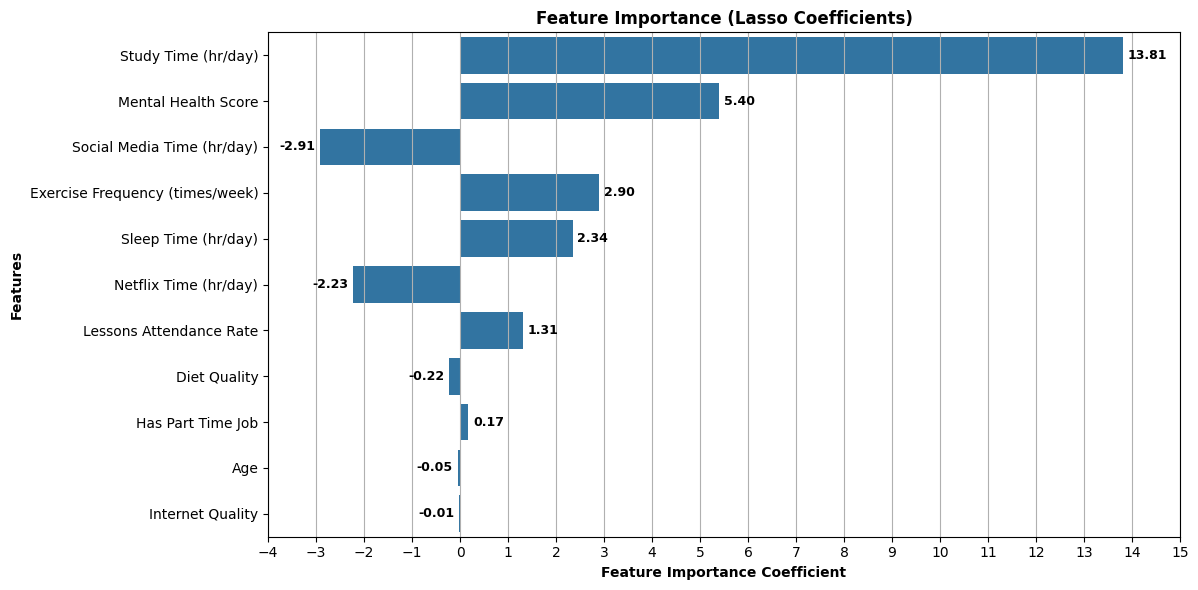

In [63]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=coef_df, x='Coefficient', y='Feature')
plt.title('Feature Importance (Lasso Coefficients)', fontweight='bold')
plt.xlabel('Feature Importance Coefficient', fontweight='bold')
plt.ylabel('Features', fontweight='bold')
plt.tight_layout()
plt.grid(axis='x')
plt.xticks(ticks=range(-4, 16, 1))
for i, (value, feature) in enumerate(zip(coef_df['Coefficient'], coef_df['Feature'])):
    ax.text(
        x=value + 0.1 if value >= 0 else value - 0.1,
        y=i,
        s=f"{value:.2f}",
        va='center', ha='left' if value >= 0 else 'right',
        fontweight='bold', fontsize=9, color='black'
    )

plt.show()

## 20. Example of Deployment Scenario

### Real-World Use Case: Early Intervention System in Educational Setting

Imagine a university implementing a digital advisory platform to support students throughout the semester.  
This platform collects lifestyle and behavioral data from students via regular surveys or app integrations.

#### Objective:
Use predictive analytics to **identify students at risk of underperforming** before final exams — and intervene with targeted support (e.g., tutoring, mental health resources, or scheduling adjustments).

---

#### Scenario:

A student advisor inputs the following details into the system based on a student check-in:

- Age  
- Study hours per day
- Social media hours  
- Netflix hours
- Part-time job 
- Attendance rate 
- Sleep time  
- Diet quality  
- Exercise weekly frequency  
- Internet quality  
- Mental health rating

The system preprocesses these values using the pipeline and feeds them into the **Lasso regression model**.

---

#### Output:
**Lets say for a chosen studen predicted Final Exam Score: 51 / 100**

Based on this result, the platform automatically flags this student as **"high-risk"**, and recommends the following actions:

- Notify the academic advisor to schedule a one-on-one session.  
- Recommend workshops on time management, productive habits, and academic planning. 
- Offer access to mental health counseling and support tools.

---

This approach enables **data-driven early intervention**, improves retention, and supports student well-being — all with minimal manual analysis.


In [64]:
# keep columns with importance rate > 0
columns_to_keep = [
     'age',
     'study_hours_per_day',
     'social_media_hours',
     'netflix_hours',
     'part_time_job',
     'attendance_percentage',
     'sleep_hours',
     'diet_quality',
     'exercise_frequency',
     'internet_quality',
     'mental_health_rating'
]

In [65]:
df_deployed = df[columns_to_keep].copy()

In [66]:
df_deployed.head(3)

,age,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,internet_quality,mental_health_rating
0,23,0.0,1.2,1.1,no,85.0,8.0,fair,6,average,8
1,20,6.9,2.8,2.3,no,97.3,4.6,good,6,average,8
2,21,1.4,3.1,1.3,no,94.8,8.0,poor,1,poor,1


In [67]:
# update the pipeline accordingly to match the final set of features used in the model
ordinal_cat_cols = ['diet_quality', 'internet_quality']
for i in ordinal_cat_cols:
    print(X_train[i].value_counts())
    print()

ordinal_cat_instructions = [
    ['poor', 'fair', 'good'],
    ['poor', 'average', 'good']
]

ct = ColumnTransformer([
    ('num_cols', StandardScaler(), make_column_selector(dtype_include='number')),
    ('ordinal_cat_cols', OrdinalEncoder(categories=ordinal_cat_instructions), ordinal_cat_cols)],
    remainder=OneHotEncoder(drop='first',handle_unknown='ignore', sparse_output=False)
)

pipeline = Pipeline(steps=[
    ('preproc', ArrayToDFTransformer(ct)),
    ('estimator', Lasso(max_iter=10000, selection='cyclic', fit_intercept=True, alpha=0.1))
])

diet_quality
fair    301
good    269
poor    130
Name: count, dtype: int64

internet_quality
good       321
average    271
poor       108
Name: count, dtype: int64



In [68]:
# train pipeline with model on full set of data
pipeline.fit(df_deployed, df['exam_score'])

Pipeline(steps=[('preproc',
                 ArrayToDFTransformer(col_transformer=ColumnTransformer(remainder=OneHotEncoder(drop='first',
                                                                                                handle_unknown='ignore',
                                                                                                sparse_output=False),
                                                                        transformers=[('num_cols',
                                                                                       StandardScaler(),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x000002C932C10620>),
                                                                                      ('ordinal_cat_cols',
                                                                                       OrdinalEncoder(categories=[['poor',
                                                                                                                   'fair',
                                                                                                                   'good'],
                                                                                                                  ['poor',
                                                                                                                   'average',
                                                                                                                   'good']]),
                                                                                       ['diet_quality',
                                                                                        'internet_quality'])]))),
                ('estimator', Lasso(alpha=0.1, max_iter=10000))])

---

We will define a flexible function that accepts either:

- **Manual input**, prompted for each feature interactively, or  
- **Predefined values**, passed as a dictionary (e.g., during deployment or testing)

This allows seamless usage both in development and in production scenarios.

---

In [69]:
# define a function to predict exam score via variable-input or manual input
def predict_student_exam_score(values_preset=None):
    questions_dict = {
        'age': 'Age',
        'study_hours_per_day': 'How many hours per day does student study?',
        'social_media_hours': 'How many hours per day does student use social media?',
        'netflix_hours': 'How many hours per day does student watch Netflix?',
        'part_time_job': 'Does student have a part-time job? (yes, no)',
        'attendance_percentage': 'Attendance percentage (in %, e.g. 70)',
        'sleep_hours': 'How many hours does student sleep per night?',
        'diet_quality': 'Diet quality (poor, fair, good)',
        'exercise_frequency': 'How many times per week does student exercise?',
        'internet_quality': 'Internet quality at home? (poor, average, good)',
        'mental_health_rating': 'Mental health rating (1–10)'
    }

    cleaned_input = {}

    if not values_preset:
        for key, question in questions_dict.items():
            input_value = input(question)
            if isinstance(input_value, str):
                input_value = input_value.strip().lower()
            try:
                cleaned_input[key] = float(input_value)
            except ValueError:
                cleaned_input[key] = input_value
    else:
        for key, value in values_preset.items():
            if isinstance(value, str):
                value = value.strip().lower()
            try:
                cleaned_input[key] = float(value)
            except (ValueError, TypeError):
                cleaned_input[key] = value

    X_input = pd.DataFrame([cleaned_input])

    prediction = int(pipeline.predict(X_input)[0])
    if prediction > 100:
        prediction = 100
    elif prediction < 0:
        prediction = 0
    print(f"\nStudent's predicted exam score is: {prediction} (with ~90% confidence).")


### Example: Predefined Values

#### values_preset template
- Put valid numbers instead of **0**'s
- Choose **one** valid option on categories
```python
values_preset = {
    'age': 0,
    'study_hours_per_day': 0,
    'social_media_hours': 0,
    'netflix_hours': 0,
    'part_time_job': 'yes'/'no',
    'attendance_percentage': 0,
    'sleep_hours': 0,
    'diet_quality': 'poor'/'fair'/'good',
    'exercise_frequency': 0,
    'internet_quality': 'poor'/'average'/'good',
    'mental_health_rating': 0
}
```

In [70]:
values_preset = {
    'age': 20,
    'study_hours_per_day': 7,
    'social_media_hours': 4,
    'netflix_hours': 4,
    'part_time_job': 'yes',
    'attendance_percentage': 3,
    'sleep_hours': 9,
    'diet_quality': 'good',
    'exercise_frequency': 1,
    'internet_quality': 'poor',
    'mental_health_rating': 5
}
predict_student_exam_score(values_preset)


Student's predicted exam score is: 84 (with ~90% confidence).


### Example: Manual Input

In [71]:
# Note: This line is intentionally commented out to prevent accidental triggering 
# of user input when executing all cells in the notebook.


#predict_student_exam_score()

#### Example of output
```python
predict_student_exam_score()

Age 20
How many hours per day does student study? 6
How many hours per day does student use social media? 2
How many hours per day does student watch Netflix? 3
Does student have a part-time job? (yes, no) yes
Attendance percentage (in %, e.g. 70) 65
How many hours does student sleep per night? 8
Diet quality (poor, fair, good) fair
How many times per week does student exercise? 3
Internet quality at home? (poor, average, good) average
Mental health rating (1–10) 6

"Student's predicted exam score is: 93 (with ~90% confidence)."
```

# Conclusion

## Project Summary

This project aimed to develop a robust machine learning pipeline to **predict students' final exam scores** based on academic, behavioral, and lifestyle-related data. Over the course of several structured stages, we performed full-cycle data science work — from cleaning raw data to final model deployment preparation.

---
###  Data Understanding & Preparation

- Performed **exploratory data analysis (EDA)** to understand distributions, correlations, and potential data issues.
- Assessed **missing values** — only one feature (`parental_education_level`) contained 91 missing entries, which were handled later during preprocessing without degrading data integrity.

- Checked **numerical feature distributions**:
  - Most numerical features distribution (e.g. `study_hours_per_day`, `sleep_hours`, `exercise_frequency`) were normal or close to normal.
  - Applied statistical checks for **skewness** and **kurtosis** — no major deviations detected; transformations were not required.
  - As example, the most important feature: `study_hours_per_day` has mean = 3.55, std = 1.47, min = 0.0, max = 8.3

- Target variable `exam_score`:
  - Mean = **69.6**, standard deviation = **16.9**
  - Min = **18.4**, max = **100**
  - Distribution is **slightly skewed towards high scores**, especially dense around the **95–100** range.
  - This is consistent with expected patterns in academic data and does not negatively impact model performance.

- Checked for **outliers** using IQR, ZScore and distribution analysis:
  - Although some high/low values were found (e.g., students with 0 hours of study or extremely high attendance), **none were dropped** as they reflected plausible behavior rather than noise.

- Validated **categorical feature distributions**:
  - Examples:
    - `diet_quality`: fair (437), good (338), poor (225)
    - `internet_quality`: good (447), average (291), poor (262)
  - Encoded values showed **no class imbalance critical enough to affect model stability**.

- Verified **absence of multicollinearity** across baseline numerical features using pairwise correlation and VIF analysis.

---
### Modeling Process

- Configured a unified **ColumnTransformer** with preprocessing logic:
  - `StandardScaler` for **numerical features**.
  - `OrdinalEncoder` for **ordinal categorical features**, selected and ordered manually.
  - `OneHotEncoder` for **nominal categorical features** (no implicit order).

- Built a **comprehensive modeling pipeline**, integrating all critical steps:
  - **Feature engineering** with domain-informed custom transformations.
  - **Multicollinearity filtering**: newly engineered features were evaluated using VIF; highly collinear ones were dropped.
  - **Preprocessing integration** through `ColumnTransformer` for streamlined handling of heterogeneous data.
  - **Model injection via loop** to test multiple regressors in a clean and ergonomic manner (code-efficient and reusable).

- Defined **regression** as the appropriate modeling objective, given the continuous nature of the target variable (`exam_score`).

- Benchmarked several classic regression models using **default settings** and **hyperparameter tuning**.
- The top three models selected based on test performance:
    - **Lasso Regression** – R² = `0.8997`
    - **Linear Regression** – R² = `0.8974`
    - **Ridge Regression** – R² = `0.8974`

- **Lasso Regression** showed slightly better performance, thanks to:
  - Built-in **L1 regularization** which suppresses irrelevant features.
  - Natural **feature selection capability**, simplifying the interpretation and reducing model complexity.

-  **Recommended deployment configuration**:
  ```python
  Lasso(max_iter=10000, selection='cyclic', fit_intercept=True, alpha=0.1)
```
### Final Evaluation Metrics

The following results were obtained from the best-performing model, Lasso Regression on the final separate test set:

| Metric               | Value     |
|----------------------|-----------|
| **R² Score**         | 0.8997    |
| **Explained Variance** | 0.8998 |
| **Mean Squared Error (MSE)** | 28.60 |
| **Median Absolute Error** | 3.54  |
| **Mean Absolute Error (MAE)** | 4.18 |
| **Root Mean Squared Error (RMSE)** | 5.35 |
| **Max Error**        | 21.42     |

These metrics confirm that the model is both **accurate and stable**, capable of delivering reliable predictions for real-world use.

---


### **Model Performance Interpretation**

Given that the target variable ranges from 0 to 100, the achieved metrics indicate **strong predictive performance**:

- An **R² score of 0.8997** means the model explains nearly **90% of the variance** in exam scores — a high level of explanatory power.
- The **RMSE of ~5.35** suggests predictions deviate, on average, by only **5 points**, which is relatively low on a 100-point scale.
- The **Max Error of ~21.42** represents the largest deviation observed on the test set. While seemingly high, it remains acceptable due to the **inherent variability in human behavior and academic performance**. This deviation may reflect genuine outliers, which are important to account for in real-world educational settings.

> **Conclusion**: The model shows **high accuracy and generalizability**, making it appropriate for practical use in forecasting student exam outcomes.


--- 

#### Finalization & Deployment

- The most influential features in the final model were:
  - `Study Time (hr/day)`
  - `Mental Health Score`

- Moderately important features included:
  - `Social Media Time (hr/day)`
  - `Exercise Frequency (times/week)`
  - `Sleep Time (hr/day)`
  - `Netflix Time (hr/day)`

- Lower-impact features (still retained for nuance and coverage):
  - `Lessons Attendance Rate`
  - `Diet Quality`
  - `Has Part Time Job`
  - `Age`
  - `Internet Quality`

> All other features were eliminated by the **Lasso regression** due to their **zero coefficients**, indicating no measurable contribution to prediction.

---

#### Example of Real-World Model Usage

This pipeline can be embedded into a web interface or dashboard where academic advisors or students themselves can enter relevant lifestyle and study-related parameters.  
The model will then provide a predicted exam score based on the input data.

Such predictions can be used to:

- Identify **at-risk students** early and proactively intervene.
- Recommend **targeted improvements**, such as increasing study time or improving sleep and mental health habits.
- Monitor **effectiveness of educational programs** by simulating performance scenarios based on behavioral changes.

---
#### Prediction Function

As part of deployment preparation, we implemented a **flexible prediction function**:

- It can take **predefined input data** (via a dictionary or preset values) for automated use-cases.
- Alternatively, it supports **interactive input mode** via terminal prompts, allowing manual prediction through a step-by-step question form.

**Note**: This function is intended as a **prototype**.  
While fully functional, it requires further optimization, input validation, and integration efforts for use in a real production environment.  
Here, it is included to demonstrate how the outcomes of this project could be practically applied.

---

This wraps up the entire pipeline from data to deployment, showing both **interpretability** and **usability** of the model in practical educational scenarios.

# Credits
---
**Author:** Oleksandr Yepur  
**Date:** June 2025  

#### Thank you for your attention and for taking the time to evaluate this work.

---